In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=12, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.19.2
pandas 0.20.3
sklearn 0.23.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# 设置 GPU 必须在程序刚开始的时候！
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')

# 设置 GPU 是否可见
# tf.config.experimental.set_visible_devices(gpus[2], 'GPU')

# 设置 GPU 逻辑切分
# tf.config.experimental.set_virtual_device_configuration(
#     gpus[2], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
#               tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])

# 设置内存自增
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
logical_gpus = tf.config.experimental.list_logical_devices('GPU')

print(tf.test.is_gpu_available())
print(len(gpus))
print(len(logical_gpus))

True
4
4


In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')

for gpu in gpus:
    print(gpu)
for cpu in cpus:
    print(cpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)

In [13]:
def make_dataset(images, labels, epochs, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size).prefetch(50)  # to speed up
    return dataset

# 分布式：每个 GPU 仍然是 256
batch_size_per_replica = 256
# batch_size = batch_size_per_replica * len(logical_gpus)
batch_size = 256
epochs = 1
train_dataset = make_dataset(x_train_scaled, y_train, epochs, batch_size)
valid_dataset = make_dataset(x_valid_scaled, y_valid, epochs, batch_size)

In [15]:
# 使用 MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                                  padding='same',
                                  activation='selu',
                                  input_shape=(28, 28, 1)))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                                  padding='same',
                                  activation='selu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3,
                                  padding='same',
                                  activation='selu'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3,
                                  padding='same',
                                  activation='selu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=3,
                                  padding='same',
                                  activation='selu'))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=3,
                                  padding='same',
                                  activation='selu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(10, activation="softmax"))

#     model.compile(loss="sparse_categorical_crossentropy",
#                   optimizer = "sgd",
#                   metrics = ["accuracy"])

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 256)       295168    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 256)       590080    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 512)        

## 自定义训练流程
1. define loss function
2. define function train_step
3. define function test_step
4. for-loop training loop

In [19]:
# loss_func 相当于一个函数指针
# reduction: 计算出一个 batch 的损失函数后该如何聚合
loss_func = keras.losses.SparseCategoricalCrossentropy(
    reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

# 还需要三个累计值：测试集上损失函数的累计值，训练集和测试集上准确率的累计值
test_loss = keras.metrics.Mean(name="test_loss")
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
test_accuracy = keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

# 定义 train_step
optimizer = keras.optimizers.SGD(lr=0.01)

# 使用 @tf.function 转化为计算图加速
@tf.function
def train_step(inputs):
    images, labels = inputs
    with tf.GradientTape() as Tape:
        predictions = model(images, trainng=True)
        loss = loss_func(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_accuracy.update_state(labels, predictions)
    return loss

@tf.function
def test_step(inputs):
    images, labels = inputs
    predictions = model(images)
    t_loss = loss_func(labels, predictions)
    test_loss.update_state(t_loss)
    test_accuracy.update_state(labels, predictions)
    
epochs = 10
for epoch in range(epochs):
    total_loss = 0.0
    num_batches = 0
    for x in train_dataset:
        start_time = time.time()
        total_loss += train_step(x)
        run_time = time.time() - start_time
        num_batches += 1
        print('\rtotal: %3.3f, num_batches: %d, '
              'average: %3.3f, time: %3.3f'
              % (total_loss, num_batches,
                 total_loss / num_batches, run_time),
              end = '')
    train_loss = total_loss / num_batches
    for x in valid_dataset:
        test_step(x)
    
    print('\rEpoch: %d, Loss: %3.3f, Acc: %3.3f, '
          'Val_Loss: %3.3f, Val_Acc: %3.3f'
          % (epoch + 1, train_loss, train_accuracy.result(),
             test_loss.result(), test_accuracy.result()))
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

TypeError: in converted code:

    <ipython-input-18-f9602d88bad0>:19 train_step  *
        predictions = model(images, trainng=True)
    /home/meprint/anaconda3/envs/xtest_gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)

    TypeError: call() got an unexpected keyword argument 'trainng'


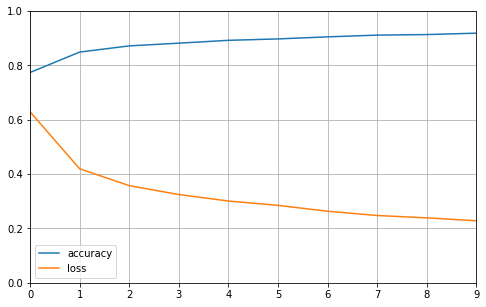

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [11]:
model.evaluate(x_test_scaled, y_test, verbose=0)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

[0.2924151478290558, 0.8945]